## Setup

In [1]:
# !pip install transformers
# !pip install sentencepiece
# !pip install jiwer
# !pip install datasets
# !pip install evaluate
# !pip install -U accelerate

# !pip install matplotlib
# !pip install protobuf==3.20.1
# !pip install tensorboard

## Imports

In [1]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from transformers import (
    VisionEncoderDecoderModel, 
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = 'false'

In [5]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training and Dataset Configurations

In [7]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 48
    EPOCHS:        int = 10
    LEARNING_RATE: float = 0.00005

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = 'input/gnhk_dataset'

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-handwritten'

## The GoodNotes Handwritten Text Dataset

```
input
└── gnhk_dataset
    ├── test_data
    ├── test_processed
    ├── train_data
    ├── train_processed
    ├── test_data.zip
    ├── test_processed.csv
    ├── train_data.zip
    └── train_processed.csv
```

In [8]:
def visualize(dataset_path, df):
    all_images = df.image_filename
    all_labels = df.text
    
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        image = plt.imread(f"{dataset_path}/test_processed/images/{all_images[i]}")
        label = all_labels[i]
        plt.imshow(image)
        plt.axis('off')
        plt.title(label)
    plt.show()

In [9]:
sample_df = pd.read_csv(
    os.path.join(DatasetConfig.DATA_ROOT, 'test_processed.csv'), 
    header=None,
    skiprows=1,
    names=['image_filename', 'text'],
    nrows=50
)

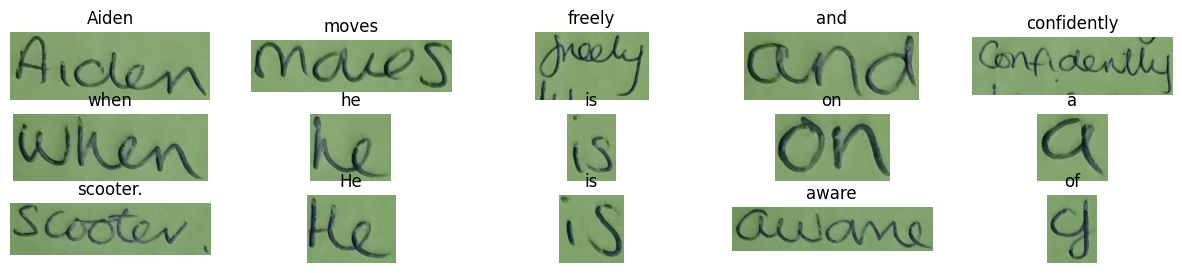

In [10]:
visualize(DatasetConfig.DATA_ROOT, sample_df)

## Prepare Dataset

In [11]:
train_df = pd.read_csv(
    os.path.join(DatasetConfig.DATA_ROOT, 'train_processed.csv'), 
    header=None,
    skiprows=1,
    names=['image_filename', 'text']
)

test_df = pd.read_csv(
    os.path.join(DatasetConfig.DATA_ROOT, 'test_processed.csv'), 
    header=None,
    skiprows=1,
    names=['image_filename', 'text']
)

In [12]:
train_df.head()

,image_filename,text
0,eng_AF_026_0.jpg,The
1,eng_AF_026_1.jpg,Yaliant
2,eng_AF_026_2.jpg,Department
3,eng_AF_026_3.jpg,Of
4,eng_AF_026_4.jpg,Sociology


In [13]:
test_df.head()

,image_filename,text
0,eng_EU_229_0.jpg,Aiden
1,eng_EU_229_1.jpg,moves
2,eng_EU_229_2.jpg,freely
3,eng_EU_229_3.jpg,and
4,eng_EU_229_4.jpg,confidently


In [14]:
# Augmentations.
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
])

In [15]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

        self.df['text'] = self.df['text'].fillna('')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['image_filename'][idx]
        # The text (label).
        text = self.df['text'][idx]
            
        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [16]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'train_processed/images/'),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'test_processed/images/'),
    df=test_df,
    processor=processor
)

/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 32495
Number of validation examples: 10066


In [18]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


(-0.5, 167.5, 122.5, -0.5)

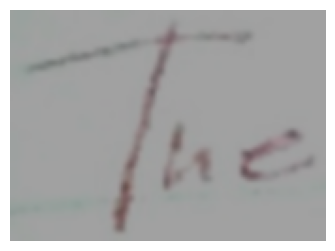

In [19]:
image = Image.open(train_dataset.root_dir + train_df['image_filename'][0]).convert("RGB")
image = train_transforms(image)
plt.figure(figsize=(5, 3))
plt.imshow(image)
plt.axis('off')

In [20]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

The


## Initialize the Model

In [21]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

## Model Configurations

In [22]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id

model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

We use the AdamW optimizer here with a weight decay of 0.0005.

In [23]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

## Evaluation Metric

In [24]:
cer_metric = evaluate.load('cer')

In [25]:
def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

## Training and Validation

In [26]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='trocr_handwritten/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS,
    dataloader_num_workers=8
)

/opt/conda/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
# Initialize trainer.
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

/opt/conda/lib/python3.11/site-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Train

In [28]:
res = trainer.train()

Epoch,Training Loss,Validation Loss,Cer
1,1.061300,0.616396,0.287112
2,0.436500,0.530803,0.259653
3,0.313800,0.546307,0.264188
4,0.233600,0.517555,0.250719
5,0.178400,0.509187,0.241862
6,0.131800,0.528024,0.241321
7,0.097000,0.519627,0.234838
8,0.070500,0.530918,0.232696
9,0.049800,0.529277,0.231210
10,0.036100,0.530724,0.230168


/opt/conda/lib/python3.11/site-packages/transformers/generation/utils.py:1375: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (http

In [29]:
res

TrainOutput(global_step=6770, training_loss=0.2608707825225424, metrics={'train_runtime': 3149.3598, 'train_samples_per_second': 103.18, 'train_steps_per_second': 2.15, 'total_flos': 3.887204217693143e+19, 'train_loss': 0.2608707825225424, 'epoch': 10.0})

## Inference

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [31]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model = VisionEncoderDecoderModel.from_pretrained('trocr_handwritten/checkpoint-'+str(res.global_step)).to(device)

/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [32]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.

    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [33]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.

    
    Returns:
        generated_text: the OCR'd text string.
    """
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [48]:
def eval_new_data(
    data_path=None,
    num_samples=50,
    df=None
):
    all_images = df.image_filename
    all_labels = df.text
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(3, 5, i+1)
        image = read_and_show(os.path.join(data_path, all_images[i]))
        text = ocr(image, processor, trained_model)
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
    plt.show()

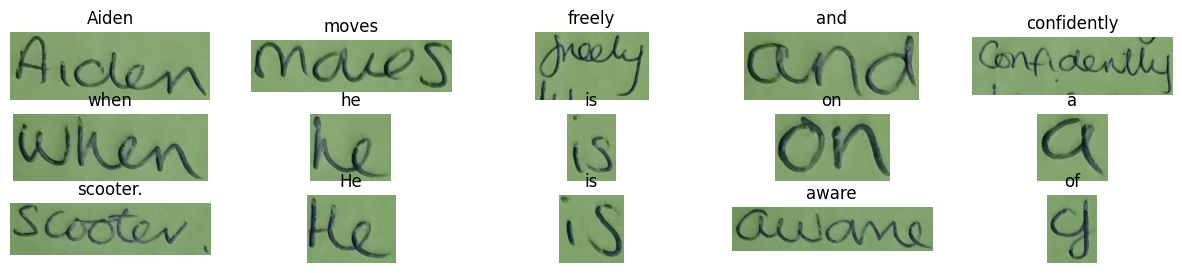

In [49]:
eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'test_processed/images'),
    num_samples=15,
    df=sample_df
)